# 지금까지 정리


딥러닝 프레임워크를 공부할 떄는 먼저, 4가지를 어떻게 하면 되는지를 알아보면 된다!

![](../../statics/imgs/4elems_dlFramework.png)

딥러닝 프로젝트를 수행하기 위해서 아래 4 단계를 구현 하면 된다. 

![](../../statics/imgs/dl_flow.png)

## 모델을 정의 하는 방법! 

1. Sequencial 사용하기  (우리가 지금까지 모델을 만들던 방식)
2. Functional API model
3. Sub class model

# Convolutional Neural Network; CNN


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
np.random.seed(7777)
tf.random.set_seed(7777)

### Convolutional Neural Network

![](../../statics/imgs/convnets-feature-maps.png)

### Filter to an image (Convolution layer)


![](../../statics/imgs/cnn.png)


## 이번 시간에는 VGGNet를 구현 해보겠습니다. 

### VGGNet 

 VGGNet은 2014년 ILSVRC에서 비록 다음에 배울 GoogLeNet에 밀려 2위를 했지만, 훨씬 간단한 구조로 이해와 변형이 쉽다는 장점이 있어 많이 응용된 모델이다.

VGGNet의 개발자들은 모델의 깊이가 성능에 얼마나 영향을 끼칠지에 집중하여 연구하였다고 논문에서 밝혔다. 깊은 네트워크를 가지고 있지만, GoogLeNet과 비교하면, 구조가 매우 간단하다. 깊이에 따른 변화를 비교하기 위해, 3x3의 작은 필터 크기를 사용했고, 모델 깊이와 구조에 변화를 주어 실험하였다. 논문에서 언급한 것은 총 6개의 모델로 내용은 다음 표와 같다. 표의 "D" 구조를 VGG16, "E" 구조를 VGG19라고 부른다. 다음 표에서, "conv 3, 64" 는 3x3 컨볼루션(convolution) 연산에 출력 피쳐맵 갯수는 64개라는 뜻이다. 

|  A  |  A-LRN  |   B   |   C   |   D   |   E   |
|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
|11개의 레이어|11개의 레이어|13개의 레이어|16개의 레이어|16개의 레이어|19개의 레이어|
|conv 3, 64|conv 3, 64|conv 3, 64|conv 3, 64|conv 3, 64|conv 3, 64| 
|          |LRN       |conv 3, 64|conv 3, 64|conv 3, 64|conv 3, 64|
| maxpool 2| maxpool 2| maxpool 2| maxpool 2| maxpool 2| maxpool 2|
|conv 3, 128|conv 3, 128|conv 3, 128|conv 3, 128|conv 3, 128|conv 3, 128|
|           |           |conv 3, 128|conv 3, 128|conv 3, 128|conv 3, 128|
| maxpool 2| maxpool 2| maxpool 2| maxpool 2| maxpool 2| maxpool 2|
|conv 3, 256|conv 3, 256|conv 3, 256|conv 3, 256|conv 3, 256|conv 3, 256|
|conv 3, 256|conv 3, 256|conv 3, 256|conv 3, 256|conv 3, 256|conv 3, 256|
|           |           |           |conv 1, 256|conv 3, 256|conv 3, 256|
|           |           |           |           |           |conv 3, 256|
| maxpool 2| maxpool 2| maxpool 2| maxpool 2| maxpool 2| maxpool 2|
|conv 3, 512|conv 3, 512|conv 3, 512|conv 3, 512|conv 3, 512|conv 3, 512|
|conv 3, 512|conv 3, 512|conv 3, 512|conv 3, 512|conv 3, 512|conv 3, 512|
|           |           |           |conv 1, 512|conv 3, 512|conv 3, 512|
|           |           |           |           |           |conv 3, 512|
| maxpool 2| maxpool 2| maxpool 2| maxpool 2| maxpool 2| maxpool 2|
|conv 3, 512|conv 3, 512|conv 3, 512|conv 3, 512|conv 3, 512|conv 3, 512|
|conv 3, 512|conv 3, 512|conv 3, 512|conv 3, 512|conv 3, 512|conv 3, 512|
|           |           |           |conv 1, 512|conv 3, 512|conv 3, 512|
|           |           |           |           |           |conv 3, 512|
| maxpool 2| maxpool 2| maxpool 2| maxpool 2| maxpool 2| maxpool 2|
| FCN 4096  | FCN 4096  | FCN 4096  | FCN 4096  | FCN 4096  | FCN 4096  |
| FCN 4096  | FCN 4096  | FCN 4096  | FCN 4096  | FCN 4096  | FCN 4096  |
| FCN 1000  | FCN 1000  | FCN 1000  | FCN 1000  | FCN 1000  | FCN 1000  |
 

### Dataloader

 - Flatten => 채널 차원 추가로 변경 
 
 (Convolution Layer는 주로 이미지데이터처리를 위해 사용되기 때문에, 컬러이미지는 (height, width, 3) 흑백은 (height, width, 1)로 사용한다.)
 
 
       ex) (num_data, 28, 28) => (num_data, 28, 28, 1)
 

In [3]:
class DataLoader():
    def __init__(self):
        # data load
        (self.train_x, self.train_y), \
            (self.test_x, self.test_y) = tf.keras.datasets.mnist.load_data()

    def scale(self, x):
        return (x / 255.0).astype(np.float32)

    def preprocess_dataset(self, dataset):

        (feature, target) = dataset

        # scaling #
        scaled_x = np.array([self.scale(x) for x in feature])

        # Add channel axis #
        expanded_x = scaled_x[:, :, :, np.newaxis] # np.newaxis : 가짜 차원 하나 추가

        # label encoding #
        ohe_y = np.array([tf.keras.utils.to_categorical(
            y, num_classes=10) for y in target])
        
        return expanded_x, ohe_y

    def get_train_dataset(self):
        return self.preprocess_dataset((self.train_x, self.train_y))

    def get_test_dataset(self):
        return self.preprocess_dataset((self.test_x, self.test_y))

In [4]:
mnist_loader = DataLoader()

train_x, train_y = mnist_loader.get_train_dataset()

print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)

test_x, test_y = mnist_loader.get_test_dataset()

print(test_x.shape, test_x.dtype)
print(test_y.shape, test_y.dtype)

(60000, 28, 28, 1) float32
(60000, 10) float32
(10000, 28, 28, 1) float32
(10000, 10) float32


## VGGNet에서 사용되는 Layer들

 - `tf.keras.layers.Conv2D`
 - `tf.keras.layers.Activation`
 - `tf.keras.layers.MaxPool2D`
 - `tf.keras.layers.Flatten`
 - `tf.keras.layers.Dense`

#### Conv2D

![](../../statics/imgs/conv2D.png)

- filters: layer에서 사용할 Filter(weights)의 갯수
- kernel_size: Filter(weights)의 사이즈  
- strides: 몇 개의 pixel을 skip 하면서 훑어지나갈 것인지 (출력 피쳐맵의 사이즈에 영향을 줌)
- padding: zero padding을 만들 것인지. VALID는 Padding이 없고, SAME은 Padding이 있음 (출력 피쳐맵의 사이즈에 영향을 줌)
- activation: Activation Function을 지정

In [15]:
tf.keras.layers.Conv2D

keras.layers.convolutional.Conv2D

In [6]:
tf.keras.layers.Conv2D(64, 3, 1, padding = 'same', activation = 'relu')

#### MaxPool2D

![](../../statics/imgs/Maxpool2D.png)

- pool_size: Pooling window 크기
- strides: 몇 개의 pixel을 skip 하면서 훑어지나갈 것인지 
- padding: zero padding을 만들 것인지

In [16]:
tf.keras.layers.MaxPool2D

keras.layers.pooling.MaxPooling2D

#### Flatten

![](../../statics/imgs/Flatten.png)

In [17]:
tf.keras.layers.Flatten

keras.layers.core.flatten.Flatten

#### Dense

![](../../statics/imgs/Dense.png)

- units : 노드 갯수
- activation : 활성화 함수
- use_bias : bias 를 사용 할 것인지
- kernel_initializer : 최초 가중치를 어떻게 세팅 할 것인지
- bias_initializer : 최초 bias를 어떻게 세팅 할 것인지

In [19]:
tf.keras.layers.Dense

keras.layers.core.dense.Dense

## Layer들을 이용해 모델 만들기 - Sequencial 방식

In [7]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [8]:
model = tf.keras.Sequential()
# 최초의 레이어는 Input의 shape을 명시해준다. (이 때 배치 axis는 무시한다.)
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(28, 28, 1))) 
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D())
model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu')) 
model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(10, activation="softmax")) # output class 개수 10

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                   

In [9]:
learning_rate = 0.03
opt = tf.keras.optimizers.Adam(learning_rate)
loss = tf.keras.losses.categorical_crossentropy

model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [10]:
# 학습
hist = model.fit(train_x, train_y,
                 epochs=2, batch_size=128,
                 validation_data=(test_x, test_y)) 
                # validation_data 를 지정해주면 .evaluate를 굳이 하지 않아도 매 epochs마다 저절로 해줌

Epoch 1/2
469/469 [==============================] - 59s 124ms/step - loss: 2.5693 - accuracy: 0.1099 - val_loss: 2.3015 - val_accuracy: 0.1135
Epoch 2/2
469/469 [==============================] - 86s 183ms/step - loss: 2.3030 - accuracy: 0.1074 - val_loss: 2.3029 - val_accuracy: 0.1135


In [11]:
hist.history

{'loss': [2.5692763328552246, 2.3030335903167725],
 'accuracy': [0.10993333160877228, 0.10743333399295807],
 'val_loss': [2.301518201828003, 2.3028743267059326],
 'val_accuracy': [0.11349999904632568, 0.11349999904632568]}

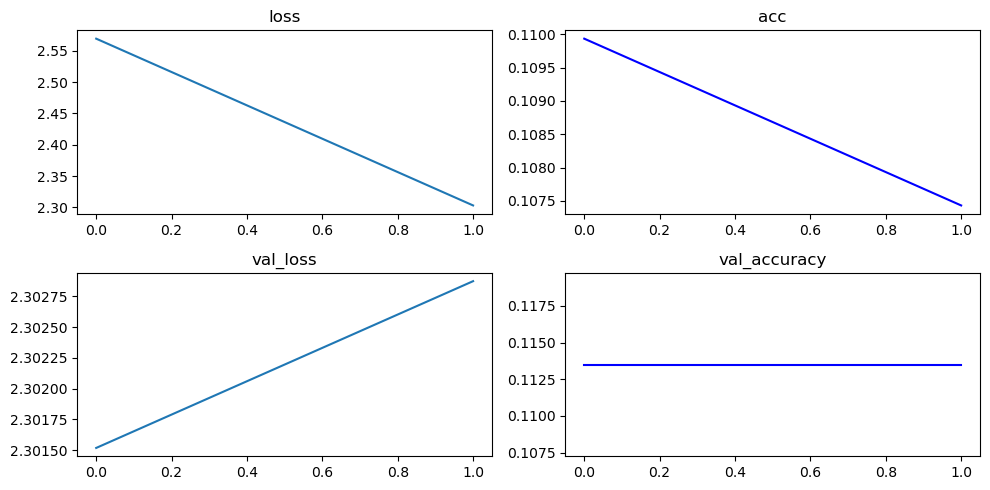

In [12]:
plt.figure(figsize=(10, 5))
plt.subplot(221)
plt.plot(hist.history['loss'])
plt.title("loss")
plt.subplot(222)
plt.plot(hist.history['accuracy'], 'b-')
plt.title("acc")
plt.subplot(223)
plt.plot(hist.history['val_loss'])
plt.title("val_loss")
plt.subplot(224)
plt.plot(hist.history['val_accuracy'], 'b-')
plt.title("val_accuracy")

plt.tight_layout()
plt.show()

모델이 간단하다면, Sequential로도 충분히 커버 가능!